# Photic Zone: Low-data-rate sensor profile reduction


Profiler sensors produce profiles that can be described approximately with a few parameters. This notebook takes up
this simplification / reduction process starting again with CTD data. See notebook Ocean 01 A for the source material.


In [171]:
import os, sys, time, glob, warnings
from IPython.display import clear_output             # use inside loop with clear_output(wait = True) followed by print(i)
warnings.filterwarnings('ignore')
this_dir = os.getcwd()
data_dir = this_dir + '/../data'

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

# convenience functions abbreviating 'datetime64' and so on
def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


### to do 

- Improve the Profile class
- Bring in kwargs for functions
- Move plot to function
- Write up the mechanics of pulling apart DataSet / DataArray
- Dual x-axis
- Create Fluorometer / CTD comparative charts
    - With chooser
- Attach a profile chooser dashboard 
- Crawler
    - calculate descent end time also
    - annotate the pH stops: both midnight and noon local
    - Annotate rest intervals on the 200m platform also
- Derivatives
    - attach the derivative plots to the main data
    - plot zero line for zero crossings in the derivative plots, flag those
- For (sensor type, ascent/descent, continuous/interval, night/day)...
    - Extract the data with time and depth
    - Smooth the data
    - Calculate first and second derivatives
    - Calculate a set of characterization values
        - Start depth
        - Depth at which signal slope (low pass) changes
        - Inflection
        - Max slope
        - Upper layer thickness
        - Boxcar standard deviation
        - And like that; and infer lenses if they are present
    - Revisit the down-sampling to one minute and the stddev signal
- Dimension is now roughly speaking a collection of profiles by sensors
    - Compare same profile different sensors
    - Compare different profile same sensors
    - Review the Arctic Great Rivers data in the sense of "29-observation axis"

In [172]:
def filter(v, ftype='hat', control1=3):
    """Operate on an XArray data array (with some checks) to produce a filtered version"""
    # pre-checks
    if not v.dims[0] == 'time': return v

    if ftype == 'hat': 
        n_passes = control1        # should be a kwarg
        len_v = len(v)
        for n in range(n_passes):
            source_data = np.copy(v) if n == 0 else np.copy(smooth_data)
            smooth_data = [source_data[i] if i == 0 or i == len_v - 1 else \
                0.5 * source_data[i] + 0.25 * (source_data[i-1] + source_data[i + 1]) \
                for i in range(len_v)]
        return smooth_data
    return v

def pull_data_array_by_name(ds, sensor_name):
    """completely extraneous (Delete Me) function"""
    return ds['sensor_name']

def dydx(y, x):
    """
    This is a simple 'centered' derivative: At location n it uses values at (n-1) and (n+1).
    Endpoints are hardcoded to zero so to do make them proper estimates.
    The sign +- also to do should be handled properly; varies with direction of profile up / down
    """ 
    len_y = len(y)
    return [0. if i == 0 or i == len_y - 1 else -(y[i+1] - y[i-1])/(x[i+1] - x[i-1]) for i in range(len_y)]

def ProfileCrawler(ds):
    """
    Walk a passed dataset to pin profiler start / stop times based on pressure
    """

    da     = ds.seawater_pressure          # data array; just time and pressure
    len_da = len(da)

    ascent_starts  = np.zeros(len_da)
    descent_starts = np.zeros(len_da)
    descent_ends   = np.zeros(len_da)
    
    threshold, nA0, nD0, nD1 = 1., 0, 0, 0

    for i in range(1, len_da - 5):         # 6 minute window
        
        # catch ascent
        if da[i-1] - da[i]   <= threshold and  \
           da[i]   - da[i+1] >= threshold and  \
           da[i+1] - da[i+2] >= threshold and  \
           da[i+2] - da[i+3] >= threshold and  \
           da[i+3] - da[i+4] >= threshold and  \
           da[i+4] - da[i+5] >= threshold:
            ascent_starts[i] = True
            nA0 += 1

        # catch descent
        if da[i-1] - da[i]   >= threshold and  \
           da[i]   - da[i+1] <= threshold and  \
           da[i+1] - da[i+2] <= threshold and  \
           da[i+2] - da[i+3] <= threshold and  \
           da[i+3] - da[i+4] <= threshold and  \
           da[i+4] - da[i+5] <= threshold:
            descent_starts[i] = True
            nD0 += 1
            
        # to do catch descent end

    # These are index-accurate float-bool numpy arrays
    return ascent_starts, descent_starts, descent_ends

In [173]:
osb_ctd_nc_file = "./data/rca/ctd/osb_ctd_jan2019_1min.nc"
ds_CTD = xr.open_dataset(osb_ctd_nc_file)
ds_CTD

<xarray.Dataset>
Dimensions:                     (time: 44640)
Coordinates:
  * time                        (time) datetime64[ns] 2019-01-01 ... 2019-01-...
Data variables:
    seawater_temperature        (time) float64 ...
    seawater_pressure           (time) float64 ...
    practical_salinity          (time) float64 ...
    corrected_dissolved_oxygen  (time) float64 ...
    density                     (time) float64 ...
Attributes:
    node:                SF01A
    id:                  RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample
    geospatial_lat_min:  44.52897
    geospatial_lon_min:  -125.38966

In [174]:
# ds_CTD is a Dataset with 44640 values, one per minute for January 2019
# ds_CTD.data_vars -> seawater_temperature, seawater_pressure, practical_salinity, corrected_dissolved_oxygen, density
# There should be 279 profiles; but 278 were found. The last profile of the month did not go.
ascent_starts, descent_starts, descent_ends = ProfileCrawler(ds_CTD)

Design the the crawler output table...

```
type,     t0,               t1,                d0,         d1,     i0,         i1,           midn,        noon,      
ascent,   2019-01-01T00:27, 2019-01-01T01:37   191.4,      6.78,   21,         91,           False,       False,
descent,                                                           91,         138,          False,       False,
rest,                                                              138,        168,          False,       False,
ascent,                                                                                      True,        False,
descent,                                                                                     True,        False,
rest,                                                                                        True,        False,
ascent,                                                                                      False,       False,
descent,                                                                                     False,       False,
rest,                                                                                        False,       False,
```

...


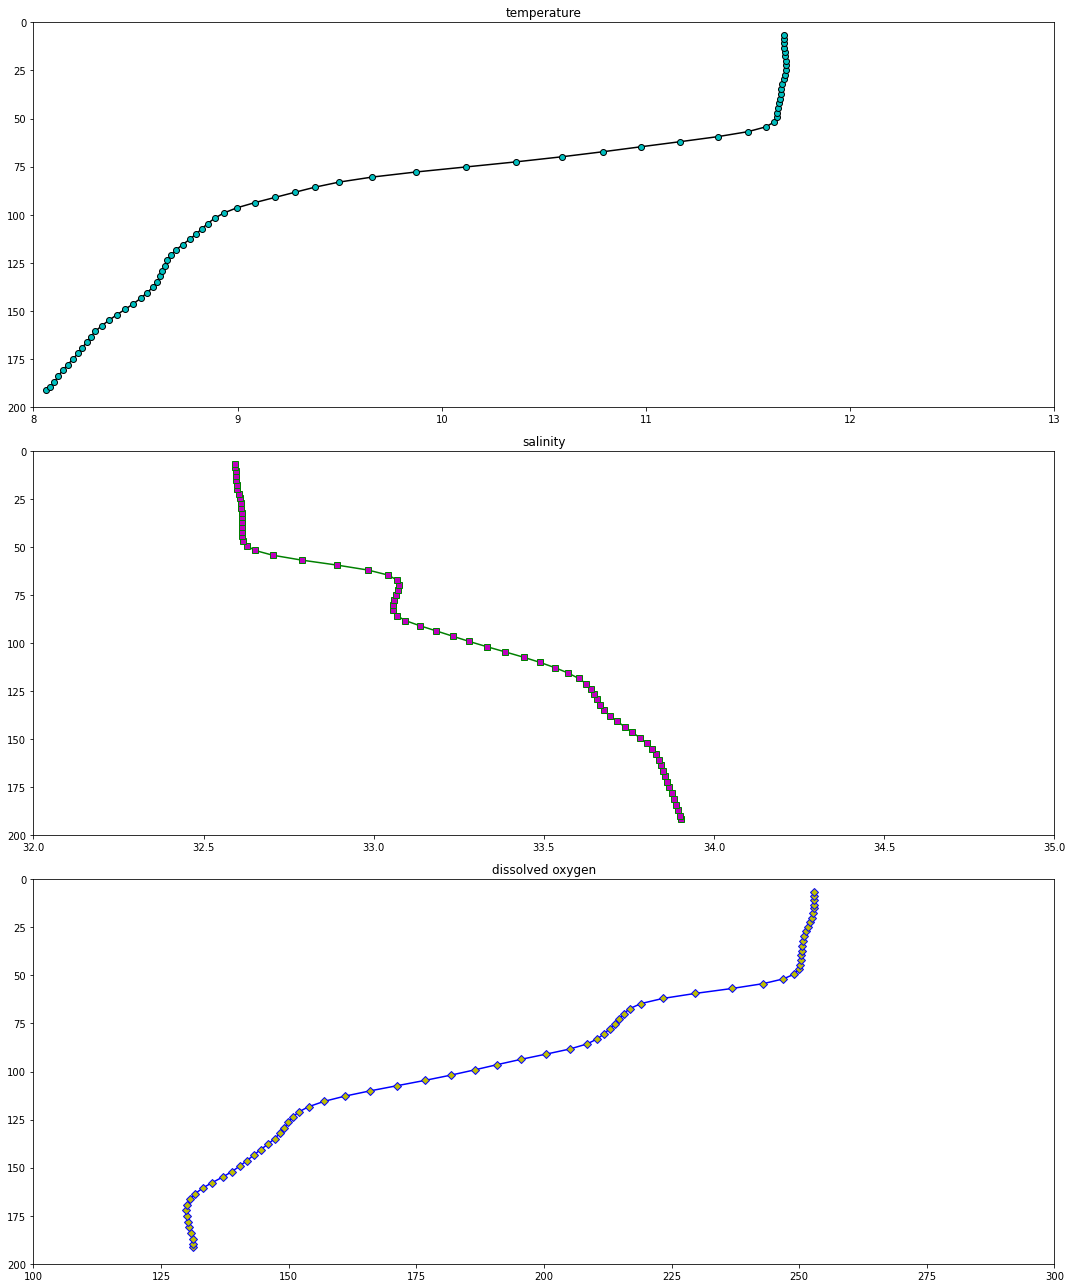

In [175]:
time0, time1 = dt64('2019-01-01T00:26:05'), dt64('2019-01-01T01:37:55')
ds_CTD_time_slice = ds_CTD.sel(time=slice(time0, time1))

sensor_t = ds_CTD_time_slice['seawater_temperature'];       smooth_t = filter(sensor_t)
sensor_s = ds_CTD_time_slice['practical_salinity'];         smooth_s = filter(sensor_s)
sensor_o = ds_CTD_time_slice['corrected_dissolved_oxygen']; smooth_o = filter(sensor_o)

sensor_d = ds_CTD_time_slice['seawater_pressure']

temperature_lbound, temperature_ubound           =   8.,  13.
salinity_lbound, salinity_ubound                 =  32.,  35.
dissolved_oxygen_lbound, dissolved_oxygen_ubound = 100., 300.

fig, axs = plt.subplots(3,1,figsize=(15,18), tight_layout=True)

compare_unfiltered = False

if compare_unfiltered:
    axs[0].plot(sensor_t + 0.5, sensor_d, marker='o', markersize = 6., color='k', markerfacecolor='r')
    axs[1].plot(sensor_s + 0.5, sensor_d, marker='s', markersize = 6., color='g', markerfacecolor='r')
    axs[2].plot(sensor_o + 20., sensor_d, marker='D', markersize = 6., color='b', markerfacecolor='r')

axs[0].plot(smooth_t, sensor_d, marker='o', markersize = 6., color='k', markerfacecolor='c')
axs[0].set(xlim = (temperature_lbound, temperature_ubound), ylim = (200., 0.), title='temperature')

axs[1].plot(smooth_s, sensor_d, marker='s', markersize = 6., color='g', markerfacecolor='m')
axs[1].set(xlim = (salinity_lbound, salinity_ubound), ylim = (200., 0.), title='salinity')

axs[2].plot(smooth_o, sensor_d, marker='D', markersize = 6., color='b', markerfacecolor='y')
axs[2].set(xlim = (dissolved_oxygen_lbound, dissolved_oxygen_ubound), ylim = (200., 0.), title='dissolved oxygen')

print('...')

[(-1.0, 6.0), (200.0, 0.0)]

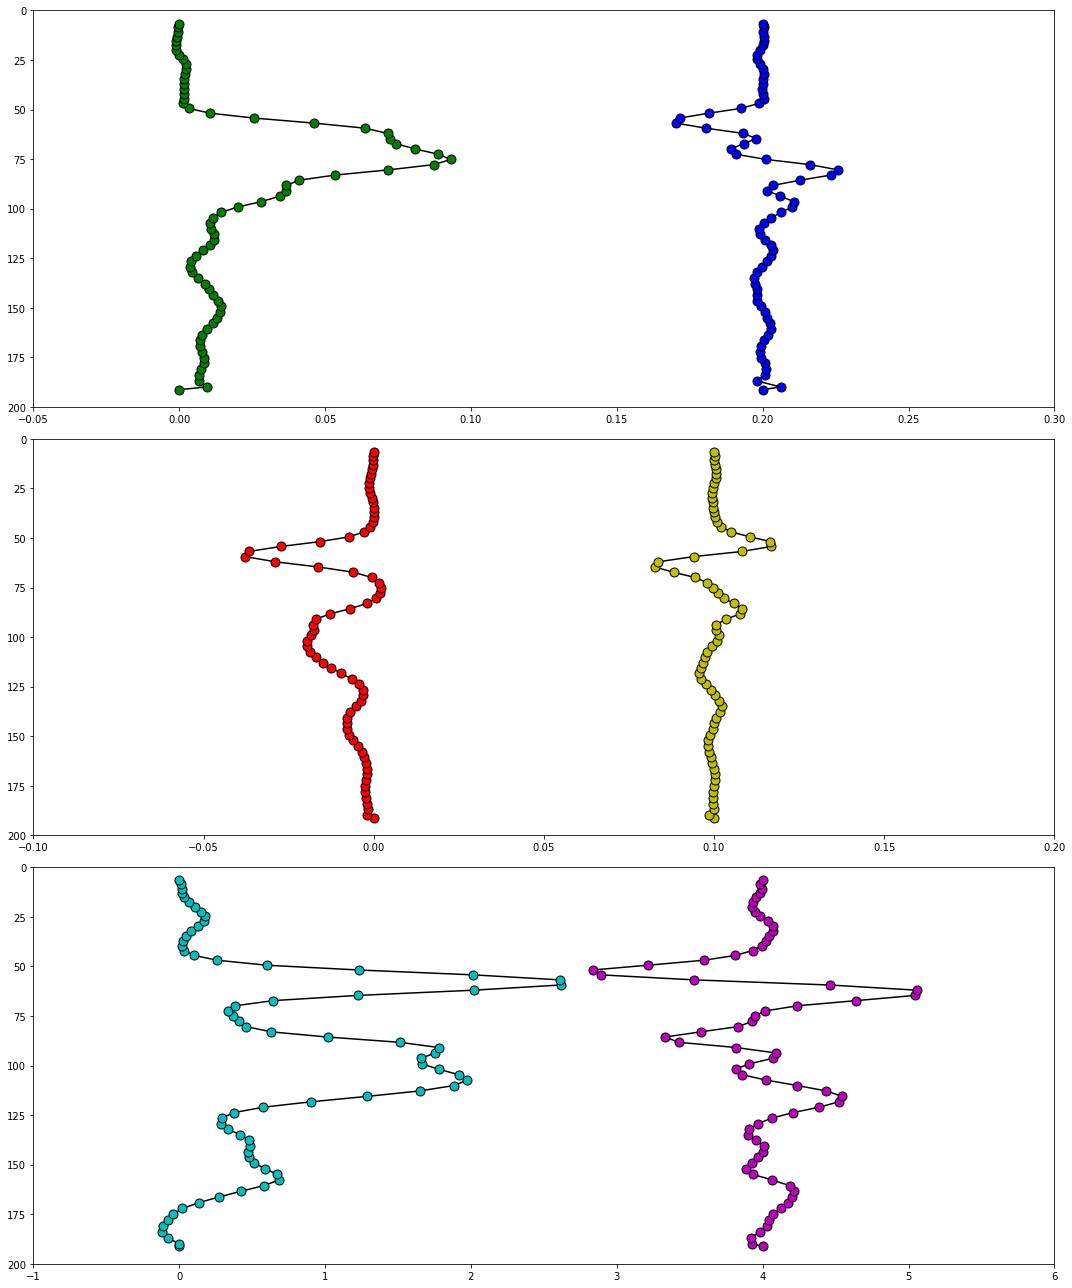

In [176]:
dydx1_t = dydx(smooth_t, sensor_d)
dydx2_t = dydx(dydx1_t, sensor_d)
dydx1_s = dydx(smooth_s, sensor_d)
dydx2_s = dydx(dydx1_s, sensor_d)
dydx1_o = dydx(smooth_o, sensor_d)
dydx2_o = dydx(dydx1_o, sensor_d)

fig, axs = plt.subplots(3,1,figsize=(15,18), tight_layout=True)

axs[0].plot(dydx1_t, sensor_d, marker='o', markersize = 9., color='k', markerfacecolor='g')
axs[0].plot(dydx2_t*np.ones(71)*4+0.2, sensor_d, marker='o', markersize = 9., color='k', markerfacecolor='b')
axs[0].set(xlim = (-.05, .3), ylim = (200., 0.))

axs[1].plot(dydx1_s, sensor_d, marker='o', markersize = 9., color='k', markerfacecolor='r')
axs[1].plot(dydx2_s*np.ones(71)*4+0.1, sensor_d, marker='o', markersize = 9., color='k', markerfacecolor='y')
axs[1].set(xlim = (-.1, .2), ylim = (200., 0.))

axs[2].plot(dydx1_o, sensor_d, marker='o', markersize = 9., color='k', markerfacecolor='c')
axs[2].plot(dydx2_o*np.ones(71)*4+4., sensor_d, marker='o', markersize = 9., color='k', markerfacecolor='m')
axs[2].set(xlim = (-1, 6.), ylim = (200., 0.))


In [177]:
sensor_d[-1]

<xarray.DataArray 'seawater_pressure' ()>
array(6.618323)
Coordinates:
    time     datetime64[ns] 2019-01-01T01:37:00
Attributes:
    comment:                  Seawater Pressure refers to the pressure exerte...
    long_name:                Seawater Pressure
    precision:                3
    data_product_identifier:  PRESWAT_L1
    standard_name:            sea_water_pressure
    units:                    dbar
    ancillary_variables:      pressure,pressure_temp
    axis:                     Z

In [178]:
class Profile:
    """A water column profile"""
    
    def __init__(self, t0='2019-01-01T00:26:05', t1='2019-01-01T01:37:55', d0=191.268063, d1=6.618323, site='osb'):
        self.t0 = dt64(t0)
        self.t1 = dt64(t1)
        self.d0 = d0
        self.d1 = d1
        self.site = site

    def readout(self):
        print("Profile start", self.t0, 'duration', self.t1 - self.t0)

p = Profile()
p.readout()

Profile start 2019-01-01T00:26:05 duration 4310 seconds


...January 2019 OSB depth profiles...


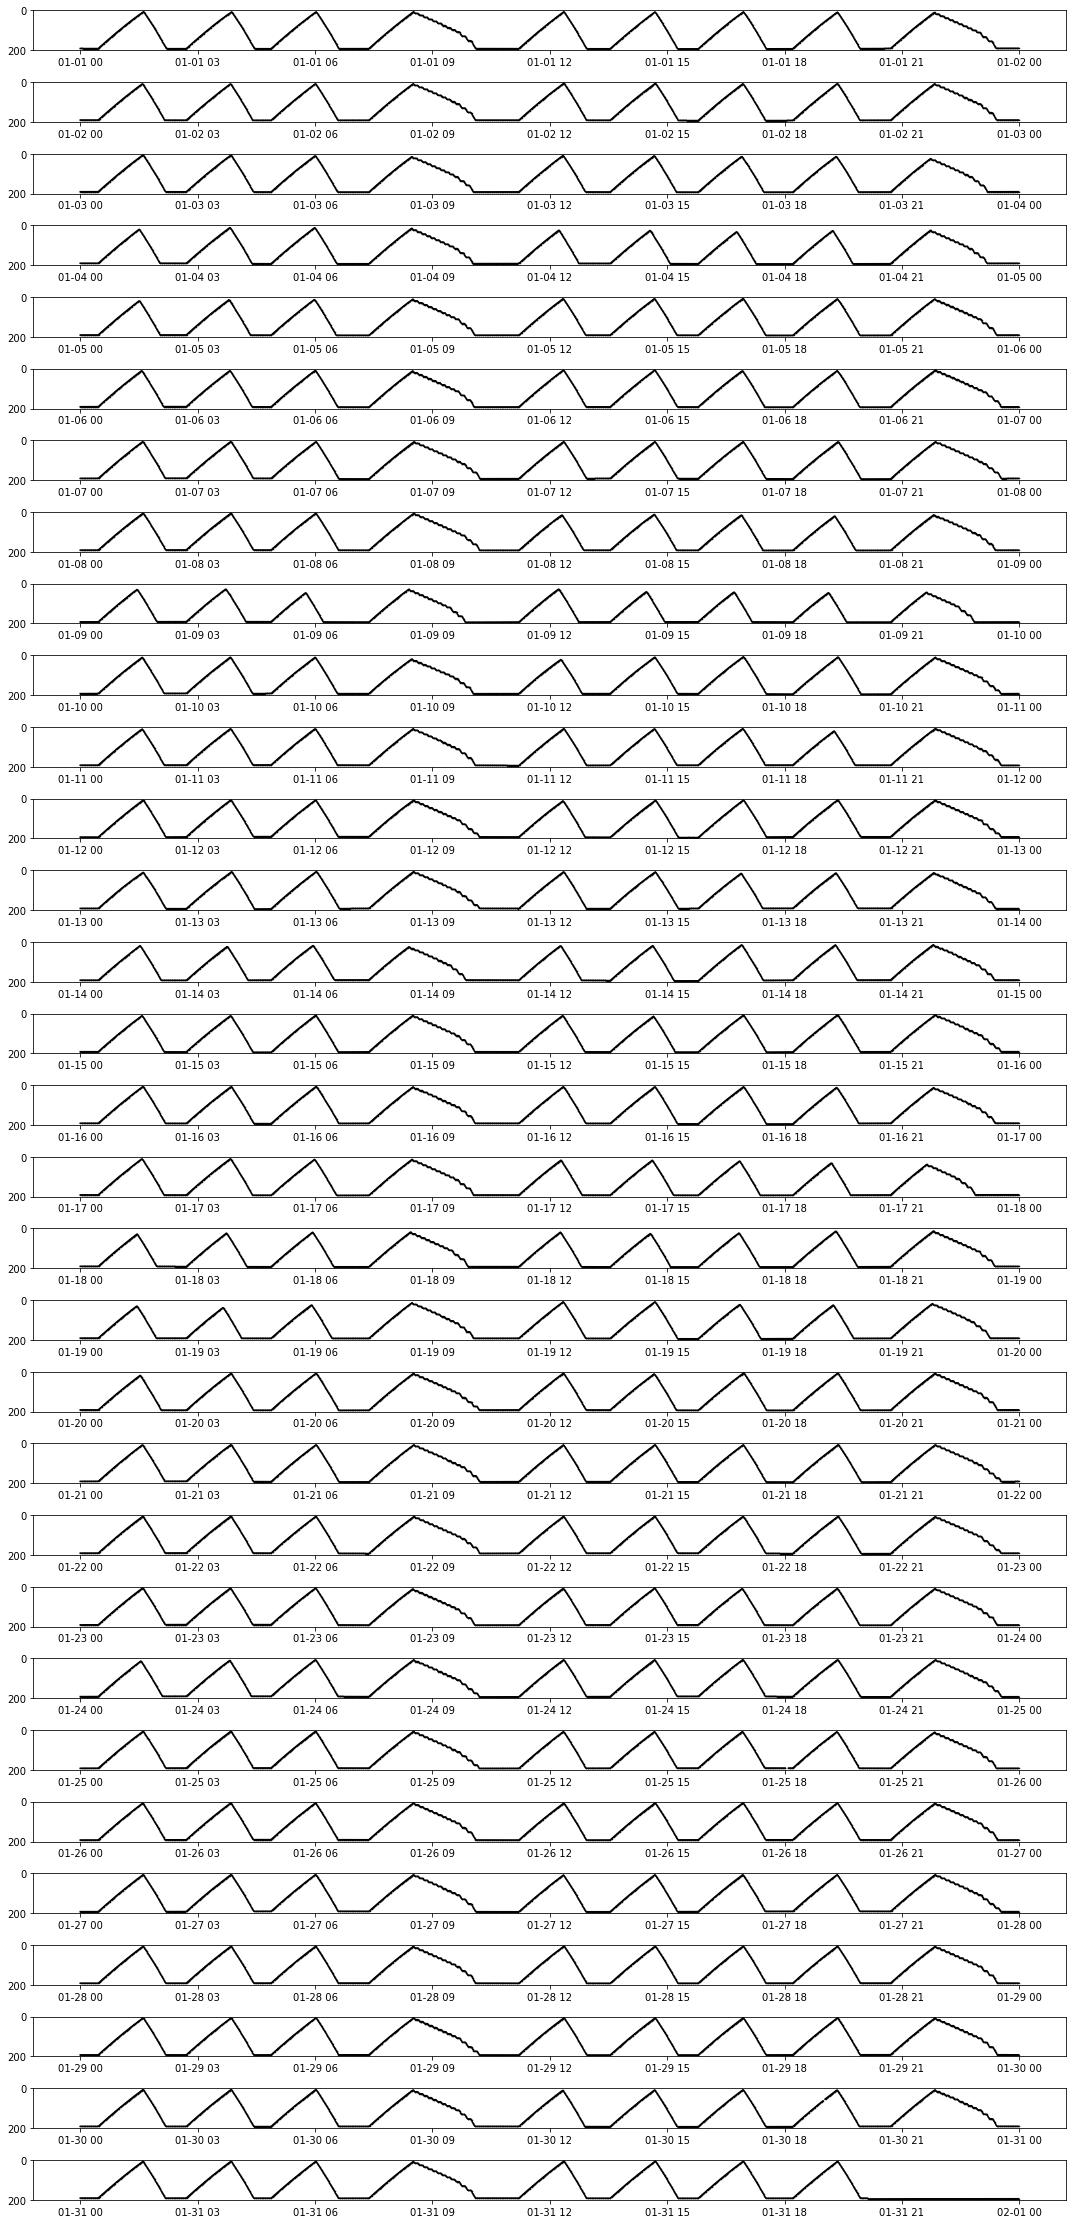

In [179]:
# January 2019 has all but one profile correct (278 / 279 possible). 
#   Missing is the last profile of the month.
# For each given UTC day: Profiles 4 and 9 are pH profiles.
#   Could use time window criteria: Hour on [6, 10] and [19, 23].

fig, axs = plt.subplots(31, 1, figsize=(15,31), tight_layout=True)

for i in range(31):
    daystring = str(i+1) if i > 8 else '0' + str(i+1)
    time0, time1 = '2019-01-' + daystring + 'T00:00:00', '2019-01-' + daystring + 'T23:59:59'
    ds = ds_CTD.sel(time=slice(time0, time1))
    axs[i].plot(ds.time, ds.seawater_pressure, marker='.', markersize=1., color='k')
    axs[i].set(ylim = (200., 0.))

print('...January 2019 OSB depth profiles...')